In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

import os
import joblib
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV,train_test_split , KFold



In [2]:

df_host = pd.read_csv('host_data.csv')
df_loc = pd.read_csv('location_data.csv')
df_pric = pd.read_csv('pricing_data.csv')
df_prop = pd.read_csv('property_data.csv')
df_rev = pd.read_csv('review_data.csv')

In [3]:
dfs = [df_host, df_loc, df_pric, df_prop, df_rev]
for i in dfs:
    print(i.isna().sum())

customer_id                   0
host_since                  173
host_response_rate        17193
host_has_profile_pic        173
host_identity_verified      173
dtype: int64
customer_id         0
neighbourhood    9550
latitude            0
longitude           0
city                0
zipcode           894
dtype: int64
customer_id            0
log_price              0
cleaning_fee           0
cancellation_policy    0
dtype: int64
customer_id        0
property_type      0
room_type          0
bedrooms          83
bathrooms        182
accommodates       0
beds             113
dtype: int64
customer_id                 0
number_of_reviews           0
review_scores_rating    15733
first_review            14932
last_review             14896
dtype: int64


In [4]:
dfs = [df_host, df_loc, df_pric, df_prop, df_rev]
for i in dfs:
    print(i.shape)
    print(i.head(1))

(69546, 5)
                                         customer_id  host_since  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...  10/07/2013   

  host_response_rate host_has_profile_pic host_identity_verified  
0               100%                    t                      t  
(69546, 6)
                                         customer_id     neighbourhood  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...  Columbia Heights   

    latitude  longitude city zipcode  
0  38.921768 -77.030985   DC   20009  
(69546, 4)
                                         customer_id  log_price  cleaning_fee  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...        4.0         False   

  cancellation_policy  
0            moderate  
(69546, 7)
                                         customer_id property_type  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...        house    

        room_type  bedrooms  bathrooms  accommodates  beds  
0   private room        1.0        1.0       

In [5]:
for i, df in enumerate(dfs, start=1):
    num_duplicates = df.duplicated(subset=['customer_id'], keep=False).sum()
    print(f"DataFrame {i}: {num_duplicates} duplicate rows based on 'customer_id'")

DataFrame 1: 2728 duplicate rows based on 'customer_id'
DataFrame 2: 2728 duplicate rows based on 'customer_id'
DataFrame 3: 2728 duplicate rows based on 'customer_id'
DataFrame 4: 2728 duplicate rows based on 'customer_id'
DataFrame 5: 2728 duplicate rows based on 'customer_id'


In [6]:
for i, df in enumerate(dfs, start=1):
    num_duplicates = df.duplicated(keep=False).sum()
    print(f"DataFrame {i}: {num_duplicates} fully identical rows")

DataFrame 1: 2728 fully identical rows
DataFrame 2: 2728 fully identical rows
DataFrame 3: 2728 fully identical rows
DataFrame 4: 2728 fully identical rows
DataFrame 5: 2728 fully identical rows


In [7]:
df_host = df_host.drop_duplicates(keep='first')
df_loc = df_loc.drop_duplicates(keep='first')
df_pric = df_pric.drop_duplicates(keep='first')
df_prop = df_prop.drop_duplicates(keep='first')
df_rev = df_rev.drop_duplicates(keep='first')
dfs = [df_host, df_loc, df_pric, df_prop, df_rev]

In [8]:
for i in dfs:
    print(i.shape)
    print(i.head(1))

(68182, 5)
                                         customer_id  host_since  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...  10/07/2013   

  host_response_rate host_has_profile_pic host_identity_verified  
0               100%                    t                      t  
(68182, 6)
                                         customer_id     neighbourhood  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...  Columbia Heights   

    latitude  longitude city zipcode  
0  38.921768 -77.030985   DC   20009  
(68182, 4)
                                         customer_id  log_price  cleaning_fee  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...        4.0         False   

  cancellation_policy  
0            moderate  
(68182, 7)
                                         customer_id property_type  \
0  4mUYtiM8BCkYchSi0rELebTJxPM68aZdKyUkER7ol5HI32...        house    

        room_type  bedrooms  bathrooms  accommodates  beds  
0   private room        1.0        1.0       

In [9]:
df = df_host.merge(df_loc, on='customer_id', how='inner') \
                   .merge(df_pric, on='customer_id', how='inner') \
                   .merge(df_rev, on='customer_id', how='inner') \
                   .merge(df_prop, on='customer_id', how='inner')
df['host_since'] = pd.to_datetime(df['host_since'])
df['first_review'] = pd.to_datetime(df['first_review'])
df['last_review'] = pd.to_datetime(df['last_review'])

In [10]:
df['host_identity_verified'].fillna(df['host_identity_verified'].mode()[0], inplace=True)
df['host_has_profile_pic'].fillna(df['host_has_profile_pic'].mode()[0], inplace=True)

df.loc[:, 'host_response_rate'] = df['host_response_rate'].astype(str).str.rstrip('%')
df.loc[:, 'host_response_rate'] = pd.to_numeric(df['host_response_rate'], errors='coerce')
df['host_response_rate'].fillna(df['host_response_rate'].median(), inplace=True)
df['host_response_rate'].isna().sum()

df['host_since'] = pd.to_datetime(df['host_since'])
df['host_since'] = (pd.to_datetime(datetime.now()) - df['host_since']).dt.days / 365
df['host_since'] = df['host_since'].fillna(df['host_since'].median())

C:\Users\dvana\AppData\Local\Temp\ipykernel_4348\3929864502.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['host_identity_verified'].fillna(df['host_identity_verified'].mode()[0], inplace=True)
C:\Users\dvana\AppData\Local\Temp\ipykernel_4348\3929864502.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

In [11]:
df.isna().sum()

customer_id                   0
host_since                    0
host_response_rate            0
host_has_profile_pic          0
host_identity_verified        0
neighbourhood              9368
latitude                      0
longitude                     0
city                          0
zipcode                     876
log_price                     0
cleaning_fee                  0
cancellation_policy           0
number_of_reviews             0
review_scores_rating      15409
first_review              14619
last_review               14583
property_type                 0
room_type                     0
bedrooms                     80
bathrooms                   177
accommodates                  0
beds                        112
dtype: int64

In [12]:
#df['host_response_rate'] = pd.to_numeric(df['host_response_rate'].str.rstrip('%'))
#Change host_since to a numeric value ( we calculate the duration)
#df['host_since'] = ((pd.to_datetime(datetime.now()) - df['host_since']).dt.days) / 365
#Change t/f to True and False
df['host_has_profile_pic'] = df['host_has_profile_pic'].map({'t': True, 'f': False}).astype(bool)
df['host_identity_verified'] = df['host_identity_verified'].map({'t': True, 'f': False}).astype(bool)
#Capatalize values in room_type and property_type to have a uniform standard between values
df['room_type'] = df['room_type'].str.upper()
df['property_type'] = df['property_type'].str.upper()

filled_loc_data = 'loc_data_filled.csv'
geolocator = Nominatim(user_agent="lazaniaa7@gmail.com")
        
def get_zipcode(lat, lon):
     try:
        location = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)
        if location and 'postcode' in location.raw['address']:
           return location.raw['address']['postcode']
     except GeocoderTimedOut:
        return None
     return None


if os.path.exists(filled_loc_data):
     df = pd.read_csv(filled_loc_data , index = False)
else:
    for idx, row in df[df['zipcode'].isna()].iterrows():
        if pd.notna(row['latitude']) and pd.notna(row['longitude']):
            zipcode = get_zipcode(row['latitude'], row['longitude'])
            df.at[idx, 'zipcode'] = zipcode

    
    
    


for i in df['zipcode'][df['neighbourhood'].isna()]:
         try:
             df.loc[(df_loc['zipcode'] == i) & (df['neighbourhood'].isna()), 'neighbourhood'] = df['neighbourhood'][df['zipcode'] == i].mode()[0]
         except:
             #NNF = NO NEIGHBOURHOOD FOUND
            df.loc[(df_loc['zipcode'] == i) & (df['neighbourhood'].isna()), 'neighbourhood'] = 'NNF'



In [13]:
print(df.shape)
print(df.duplicated().sum())


(68182, 23)
0


In [14]:
df.isna().sum()

customer_id                   0
host_since                    0
host_response_rate            0
host_has_profile_pic          0
host_identity_verified        0
neighbourhood              9368
latitude                      0
longitude                     0
city                          0
zipcode                     876
log_price                     0
cleaning_fee                  0
cancellation_policy           0
number_of_reviews             0
review_scores_rating      15409
first_review              14619
last_review               14583
property_type                 0
room_type                     0
bedrooms                     80
bathrooms                   177
accommodates                  0
beds                        112
dtype: int64

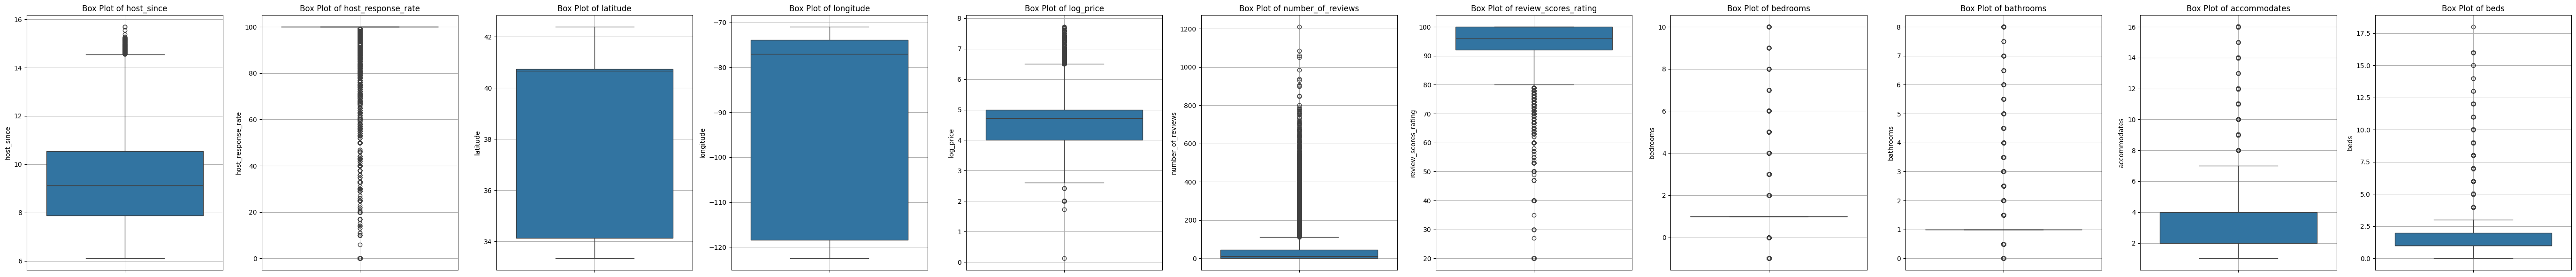

In [15]:
numerical_cols = df.select_dtypes(include=['number']).columns

num_cols = len(numerical_cols)
fig, axes = plt.subplots(1, num_cols, figsize=(5 * num_cols, 6))
for ax, col in zip(axes, numerical_cols):
    sns.boxplot(data=df, y=col, ax=ax)
    ax.set_title(f'Box Plot of {col}')
    ax.set_ylabel(col)
    ax.grid(True)
plt.tight_layout()
plt.show()

In [16]:
df['zipcode'] = pd.to_numeric(df['zipcode'].str[:5].str.zfill(5), errors='coerce')

In [17]:
cols_to_drop = ['customer_id' , 'first_review' , 'last_review' ]
df = df.drop(columns=cols_to_drop, axis = 1)

In [18]:
categorical_columns = [ 'city', 'cancellation_policy', 'property_type', 'room_type','neighbourhood']

df_with_dummies = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [19]:
model_scores = {}
X = df_with_dummies.drop(columns=['log_price'])
y = df_with_dummies['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
import os
import joblib
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

saved_model_name = 'model_xgb_TUNED.joblib'

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

if os.path.exists(saved_model_name):
    loaded_model = joblib.load(saved_model_name)
    model_xgb_TUNED = loaded_model
else:
    grid_search = GridSearchCV(XGBRegressor(enable_categorical=True), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    model_xgb_TUNED = grid_search.best_estimator_
    joblib.dump(model_xgb_TUNED, saved_model_name)

y_pred = model_xgb_TUNED.predict(X_test)

train_score = model_xgb_TUNED.score(X_train, y_train)
test_score = model_xgb_TUNED.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

params = model_xgb_TUNED.get_xgb_params()

model_scores['XGBoost TUNED'] = {
    'Train Score': train_score,
    'Test Score': test_score,
    'Used Parameters': params
}

print(f"Train Score (R²): {train_score}")
print(f"Test Score (R²): {test_score}")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")